In [1]:
from implicit_als.read_dump import read_dump
import pandas as pd
import matplotlib.pyplot as plt

# Convert data

sql dump -> csv. Next load the data to the table

In [2]:
dataname = 'all'

path = '/data/groupLe_recsys/{s}/raw/{s}-recommender-users.sql'.format(s=dataname)
csv_path = '/data/groupLe_recsys/{}/views.csv'.format(dataname)
table = '{}_recomm'.format(dataname)

In [5]:
read_dump(path, table, csv_path)

865it [00:25, 33.42it/s]


0

In [6]:
df = pd.read_csv(csv_path, header=None, na_values='NULL')

if dataname == 'all':
    df.columnsmns = 'item_id site_id rate user_id status'.split()
else:
    df.columns = 'item_id rate user_id status'.split()
# df = df.drop('date_created', axis=1)
df.head()

,item_id,rate,user_id,status
0,3,10.0,21596,2
1,3,10.0,95282,2
2,3,10.0,59972,2
3,3,9.0,48468,4
4,3,NaN,6059,8


In [7]:
df.shape

(20246794, 4)

# delete NA

In [8]:
print('na percent', round(df[df.rate.isna()].shape[0]/df.shape[0]*100, 2))

na percent 0.1


In [9]:
df.isna().sum()

item_id        0
rate       20926
user_id        0
status         0
dtype: int64

In [10]:
df = df[~df.rate.isna()]

# View data

In [ ]:
hist_params = {'bins': 400, 'figsize': (25, 2)}

<AxesSubplot:>

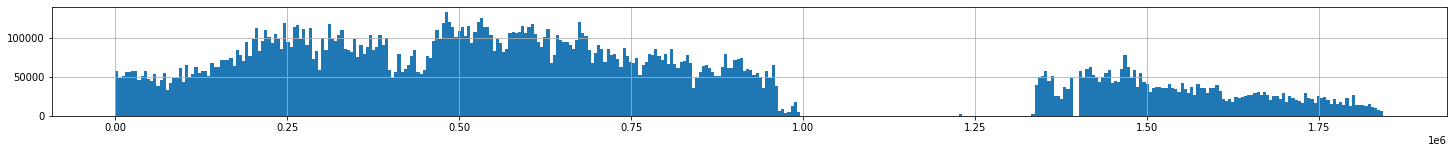

In [45]:
# id пользователей
df.user_id.hist(**hist_params)

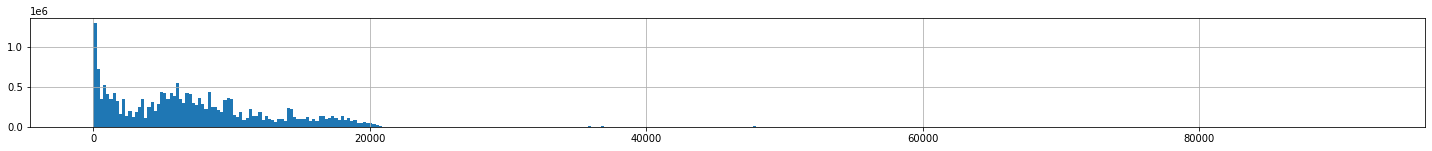

In [46]:
# id объектов
df.item_id.hist(**hist_params)
plt.savefig('./plot.png')

In [47]:
print(df.item_id.drop_duplicates().shape[0], 'уникальных объектов')
print(df.user_id.drop_duplicates().shape[0], 'уникальных пользователей')

32521 уникальных объектов
230471 уникальных пользователей


<AxesSubplot:>

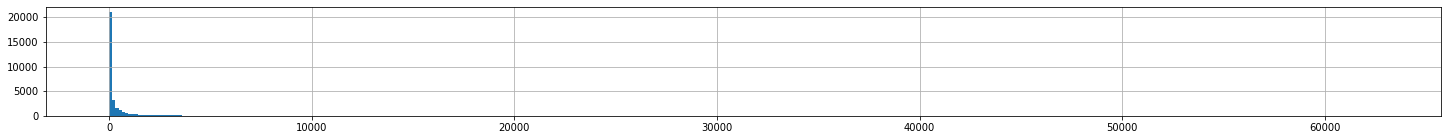

In [31]:
# Количество оценок для каждого объекта
df.groupby('item_id').count()['rate'].hist(**hist_params)

<AxesSubplot:>

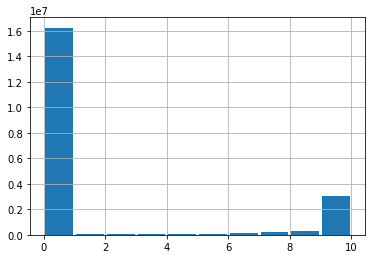

In [11]:
# Как оценивают
df.rate.hist(bins=10, rwidth=0.9)
# plt.savefig('rates.png')

<AxesSubplot:>

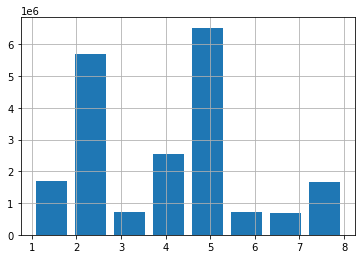

In [12]:
# Статусы
df.status.hist(bins=df.status.drop_duplicates().shape[0],rwidth=0.8)

In [ ]:
df.rate.drop_duplicates()

# Clean data

In [13]:
from implicit_als.preprocessor import Preprocessor

In [14]:
preprocessor = Preprocessor()

# df = preprocessor.filter_zeros(df)
df = preprocessor.filter_lazy_users(df, 0)

df = df.drop('status', axis=1)

In [15]:
df.shape

(17928071, 3)

In [16]:
df.to_csv(csv_path, index=False)

# Split data

In [17]:
from tqdm.notebook import tqdm
from random import shuffle
import numpy as np

In [18]:
user_freqs = list(zip(df.user_id.drop_duplicates().sort_values().tolist(), df.groupby('user_id').count()['rate'].sort_index().to_list()))
user_freqs = {item[0] : item[1] for item in user_freqs}

if dataname == 'book':
    min_freq = 3
else:
    min_freq = 30
max_freq = float('inf')

avg_users = [key if 
                 val > min_freq and \
                 val < max_freq 
                 else None 
             for key, val in user_freqs.items()]

avg_users = list(filter(lambda x: x != None, avg_users))
print(round(len(avg_users) / df.user_id.drop_duplicates().shape[0] * 100, 1), '%')

49.4 %


In [19]:
print(df.shape[0])
df = df[df.user_id.isin(avg_users)]
print(df.shape[0])

17928071
17309504


In [20]:
df.groupby('user_id').count()['rate'].hist(**hist_params)

NameError: name 'hist_params' is not defined

In [21]:
users_sessions = df.groupby('user_id')['item_id rate'.split()].apply(lambda l: list(zip(
                                                                                    l['item_id'].tolist(), 
                                                                                    l['rate'].tolist()
                                                                                    )
                                                                                ))

In [ ]:
test_k = min_freq // 2

test_df = []
train_df= []

for user, history in tqdm(list(zip( users_sessions.index.tolist(), users_sessions.tolist() ))):
    views = [(user, item, rate) for item, rate in history]
    np.random.shuffle(views)
    test_views = views[:test_k]
    train_views= views[test_k:]
    
    test_df += test_views
    train_df += train_views
    
train_df = pd.DataFrame.from_records(train_df, columns='user_id item_id rate'.split())
test_df = pd.DataFrame.from_records(test_df, columns='user_id item_id rate'.split())

In [ ]:
train_df.shape, test_df.shape

In [ ]:
train_df.to_csv(csv_path.replace('views.csv', 'train/views.csv'), index=False)
test_df.to_csv(csv_path.replace('views.csv', 'test/views.csv'), index=False)

In [ ]:
df = pd.read_csv('/data/groupLe_recsys/dorama/views.csv')
df.head()

In [ ]:
df.astype(int)